# Import necessary libraries:

In [18]:
print("hey")

hey


In [19]:
import os
import numpy as np
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt


ModuleNotFoundError: No module named 'tensorflow.python.trackable'

# Define parameters and initialize dataset:

In [ ]:
dataset_path = "C:\Users\Welcome\Downloads\Mango Leaf Disease Detection Dataset"
image_size = (320, 240)
num_classes = 8

images = []
labels = []


# Load dataset and preprocess images:

In [ ]:
for folder_name in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder_name)
    label = os.listdir(dataset_path).index(folder_name)

    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        image = cv2.imread(image_path)

        if image is not None and image.shape == image_size + (3,):
            images.append(image)
            labels.append(label)

images = np.array(images, dtype=np.float32)
labels = np.array(labels)


In [ ]:

import glob

folders = [folder for folder in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, folder))]

# Initialize an empty list to store counts
counts = []

# Iterate through the folders and count the number of images in each folder
for folder_name in folders:
    folder_path = os.path.join(dataset_path, folder_name)
    image_count = len(glob.glob(os.path.join(folder_path, "*.jpg")))
    counts.append(image_count)

# Plot the bar chart
plt.bar(folders, counts)
plt.xlabel('Leaf Diseases')
plt.ylabel('Number of Images')
plt.title('Number of Images per Leaf Disease')
plt.xticks(rotation=45)  
plt.show()


# Visualize some of the images

In [ ]:
import random

fig, axes = plt.subplots(2, 4, figsize=(15, 6))
axes = axes.ravel()

folder_names = os.listdir(dataset_path)

for i, folder_name in enumerate(folder_names):
    folder_path = os.path.join(dataset_path, folder_name)
    label = folder_names.index(folder_name)
    
    image_name = random.choice(os.listdir(folder_path))
    image_path = os.path.join(folder_path, image_name)
    image = cv2.imread(image_path)
    
    if image is not None:
        img = image.astype('uint8')
        axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axes[i].set_title(f"Label: {label}", fontsize=12)
        plt.subplots_adjust(hspace=0.5)
        axes[i].axis('off')

plt.show()



# Preprocess images and split the dataset:

In [ ]:
images = images / 255.0
labels = to_categorical(labels, num_classes)

X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



# data augmentation, apply the different augmentation techniques using

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Take a single image from the training set
example_image = X_train[0]
example_label = y_train[0]

# Expand the dimensions of the image to match the input shape of the data generator
example_image = np.expand_dims(example_image, axis=0)

# Configure the data generator to apply the augmentation only once
datagen_example = datagen.flow(example_image, batch_size=1)

# Generate and display 10 augmented images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i in range(10):
    augmented_image = datagen_example.next()[0]  # Generate the next augmented image
    augmented_image = np.squeeze(augmented_image)  # Remove the extra dimension
    # Convert the image from BGR to RGB format
    rgb_image = cv2.cvtColor((augmented_image * 255).astype(np.uint8), cv2.COLOR_BGR2RGB)
    axes[i].imshow(rgb_image)
    axes[i].set_title(f"Label: {np.argmax(example_label)}", fontsize=12)
    plt.subplots_adjust(hspace=0.5)
    axes[i].axis('off')

plt.show()


# Basic CNN model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(320, 240, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
batch_size = 32
epochs = 10
steps_per_epoch = X_train.shape[0] // batch_size
validation_steps = X_test.shape[0] // batch_size
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=(X_val, y_val),
                    validation_steps=validation_steps)


In [ ]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

# Display the results
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')


In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="Validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))
ax1.set_title('Loss')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
ax2.set_yticks(np.arange(0, 1, 0.1))
ax2.set_title('Accuracy')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()

plt.show()


# 2nd cnn model with improved 

In [ ]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(320, 240, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
import time

start_time = time.process_time()

batch_size = 32
epochs = 10
steps_per_epoch = X_train.shape[0] // batch_size
validation_steps = X_test.shape[0] // batch_size
history = model_1.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=(X_val, y_val),
                    validation_steps=validation_steps)

end_time = time.process_time()
cpu_time = end_time - start_time
print("CPU time taken: {:.2f} seconds".format(cpu_time))


In [ ]:
# Evaluate the model on test data
test_loss, test_accuracy = model_1.evaluate(X_test, y_test, verbose=0)

# Display the results
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')


In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="Validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))
ax1.set_title('Loss')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
ax2.set_yticks(np.arange(0, 1, 0.1))
ax2.set_title('Accuracy')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()

plt.show()


# Define and compile the model:


In [ ]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(320, 240, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
import time

start_time = time.process_time()

batch_size = 32
epochs = 10
steps_per_epoch = X_train.shape[0] // batch_size
validation_steps = X_test.shape[0] // batch_size
history = model_2.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=(X_val, y_val),
                    validation_steps=validation_steps)

end_time = time.process_time()
cpu_time = end_time - start_time
print("CPU time taken: {:.2f} seconds".format(cpu_time))


In [ ]:
# Evaluate the model on test data
test_loss, test_accuracy = model_2.evaluate(X_test, y_test, verbose=0)

# Display the results
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="Validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))
ax1.set_title('Loss')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
ax2.set_yticks(np.arange(0, 1, 0.1))
ax2.set_title('Accuracy')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()

plt.show()

# another model

In [ ]:
model_3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(320, 240, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Train the model:

In [ ]:
import time

start_time = time.process_time()

batch_size = 32
epochs = 10
steps_per_epoch = X_train.shape[0] // batch_size
validation_steps = X_test.shape[0] // batch_size
history = model_3.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=(X_val, y_val),
                    validation_steps=validation_steps)

end_time = time.process_time()
cpu_time = end_time - start_time
print("CPU time taken: {:.2f} seconds".format(cpu_time))


In [ ]:
# Evaluate the model on test data
test_loss, test_accuracy = model_3.evaluate(X_test, y_test, verbose=0)

# Display the results
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')


In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="Validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))
ax1.set_title('Loss')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
ax2.set_yticks(np.arange(0, 1, 0.1))
ax2.set_title('Accuracy')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()

plt.show()


In [ ]:

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Load dataset
# (your dataset loading code here)
images = np.array(images, dtype=np.float32)
labels = np.array(labels)

images = images / 255.0

# Convert one-hot encoded labels back to the original format
labels = np.argmax(labels, axis=1)


X_temp, X_test, y_temp, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# Flatten the images
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
start_time = time.process_time()
# Train an SVM
svm = SVC(kernel='linear', C=1)
svm.fit(X_train_flat, y_train)

# Evaluate the SVM
y_pred_train = svm.predict(X_train_flat)
y_pred_val = svm.predict(X_val_flat)
y_pred_test = svm.predict(X_test_flat)

train_accuracy = accuracy_score(y_train, y_pred_train)
val_accuracy = accuracy_score(y_val, y_pred_val)
test_accuracy = accuracy_score(y_test, y_pred_test)


end_time = time.process_time()
cpu_time = end_time - start_time
print("CPU time taken: {:.2f} seconds".format(cpu_time))
print(f"Train accuracy: {train_accuracy:.2f}")
print(f"Validation accuracy: {val_accuracy:.2f}")
print(f"Test accuracy: {test_accuracy:.2f}")


In [ ]:
from skimage.feature import hog
from sklearn.decomposition import PCA

# Function to extract HOG features
def extract_hog_features(images):
    hog_features = []
    for img in images:
        feature = hog(img, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), multichannel=True)
        hog_features.append(feature)
    return np.array(hog_features)

# Extract HOG features
X_train_hog = extract_hog_features(X_train)
X_val_hog = extract_hog_features(X_val)
X_test_hog = extract_hog_features(X_test)

# Apply PCA
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train_hog)
X_val_pca = pca.transform(X_val_hog)
X_test_pca = pca.transform(X_test_hog)

# Train an SVM
start_time = time.process_time()
svm = SVC(kernel='linear', C=1)
svm.fit(X_train_pca, y_train)

# Evaluate the SVM
y_pred_train = svm.predict(X_train_pca)
y_pred_val = svm.predict(X_val_pca)
y_pred_test = svm.predict(X_test_pca)

train_accuracy = accuracy_score(y_train, y_pred_train)
val_accuracy = accuracy_score(y_val, y_pred_val)
test_accuracy = accuracy_score(y_test, y_pred_test)
end_time = time.process_time()
cpu_time = end_time - start_time
print("CPU time taken: {:.2f} seconds".format(cpu_time))
print(f"Train accuracy: {train_accuracy:.2f}")
print(f"Validation accuracy: {val_accuracy:.2f}")
print(f"Test accuracy: {test_accuracy:.2f}")


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


# Split the data into train, validation, and test sets
X_temp, X_test, y_temp, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# Flatten the images
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
start_time = time.process_time()
# Train a Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_flat, y_train)

# Evaluate the Random Forest
y_pred_train_rf = rf.predict(X_train_flat)
y_pred_val_rf = rf.predict(X_val_flat)
y_pred_test_rf = rf.predict(X_test_flat)

train_accuracy_rf = accuracy_score(y_train, y_pred_train_rf)
val_accuracy_rf = accuracy_score(y_val, y_pred_val_rf)
test_accuracy_rf = accuracy_score(y_test, y_pred_test_rf)
end_time = time.process_time()
cpu_time = end_time - start_time
print("CPU time taken: {:.2f} seconds".format(cpu_time))
print(f"Random Forest Train accuracy: {train_accuracy_rf:.2f}")
print(f"Random Forest Validation accuracy: {val_accuracy_rf:.2f}")
print(f"Random Forest Test accuracy: {test_accuracy_rf:.2f}")



In [3]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

ModuleNotFoundError: No module named 'tensorflow.python.trackable'

In [4]:
# Parameters
dataset_path = "C:/Users/Manish Karki/Untitled Folder 3/archive"
image_size = (320, 240)
num_classes = 8

# Load dataset
images = []
labels = []

for folder_name in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder_name)
    label = os.listdir(dataset_path).index(folder_name)

    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        image = cv2.imread(image_path)

        if image is not None and image.shape == image_size + (3,):
            images.append(image)
            labels.append(label)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:/Users/Manish Karki/Untitled Folder 3/archive'

In [5]:
images = np.array(images, dtype=np.float32)
labels = np.array(labels)

images = images / 255.0
labels = to_categorical(labels, num_classes)

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Load the VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(320, 240, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model with the VGG16 base model and custom top layers
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Train the model
start_time = time.process_time()

batch_size = 32
epochs = 20
steps_per_epoch = X_train.shape[0] // batch_size
validation_steps = X_test.shape[0] // batch_size
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=(X_test, y_test),
                    validation_steps=validation_steps)
end_time = time.process_time()
cpu_time = end_time - start_time
print("CPU time taken: {:.2f} seconds".format(cpu_time))

NameError: name 'to_categorical' is not defined

In [6]:
models = ['CNN base model', 'CNN model_1', 'CNN model_2', 'CNN model_3', 'SVM', 'Improved SVM', 'Random Forest', 'Improved VGG-16']
training_times = [8230.12, 10470.12, 13024.64, 16186.67, 591.30, 0.83, 11.25, 23618.44]

# Create the bar graph
plt.figure(figsize=(12, 6))
plt.bar(models, training_times)
plt.xlabel('Models')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time for Different Models')

# Display the bar graph
plt.show()



NameError: name 'plt' is not defined

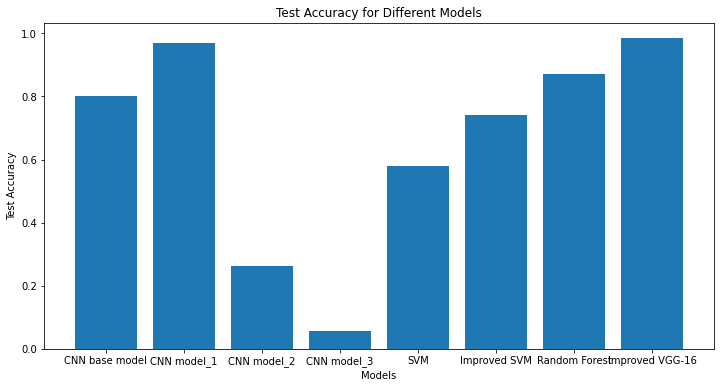

In [7]:
import matplotlib.pyplot as plt

# Model names
models = ['CNN base model', 'CNN model_1', 'CNN model_2', 'CNN model_3', 'SVM', 'Improved SVM', 'Random Forest', 'Improved VGG-16']

# Test accuracy values
test_accuracy = [0.8010, 0.9686, 0.2618, 0.0576, 0.58, 0.74, 0.87, 0.9843]

# Create the bar graph
plt.figure(figsize=(12, 6))
plt.bar(models, test_accuracy)
plt.xlabel('Models')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy for Different Models')

# Display the bar graph
plt.show()


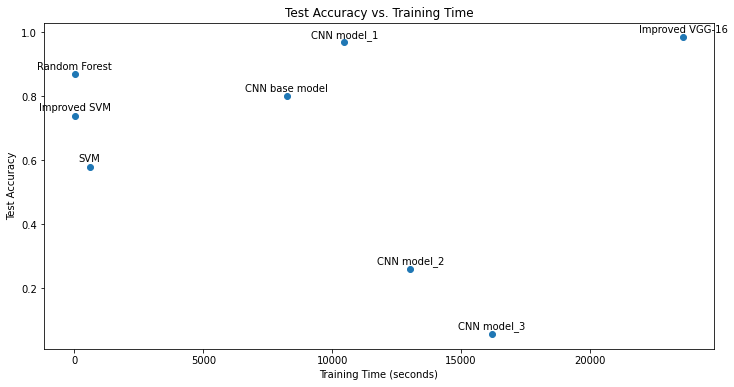

In [8]:
import matplotlib.pyplot as plt

# Create the scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(training_times, test_accuracy, marker='o')
plt.xlabel('Training Time (seconds)')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Training Time')

# Label each point with the corresponding model name
for i, model in enumerate(models):
    plt.annotate(model, (training_times[i], test_accuracy[i]), textcoords="offset points", xytext=(0,5), ha='center')

# Display the scatter plot
plt.show()


In [9]:
import numpy as np
import matplotlib.pyplot as plt

random_index = np.random.randint(0, len(X_test))

# Get the corresponding image and label
test_image = X_test[random_index]
test_label = y_test[random_index]
input_image = np.expand_dims(test_image, axis=0)


prediction = model_1.predict(input_image)
predicted_class = np.argmax(prediction)
true_class = np.argmax(test_label)
print("True class: {}, Predicted class: {}".format(true_class, predicted_class))

plt.imshow(test_image)
plt.title("True class: {} | Predicted class: {}".format(true_class, predicted_class))
plt.axis("off")
plt.show()


NameError: name 'X_test' is not defined